In [1]:
import pycrfsuite

In [2]:
from collections import Counter
import numpy as np
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [5]:
from _chain import Chain, f_phi, f_psi
from _chain_bp_loss import belief_propagation_cross_entropy_loss
from _data_utils import ChainDataset, count_parameters

In [6]:
import progressbar

### Define Binary HMM 

In [105]:
phi = f_phi(b=[-0.8, 1])
psi = f_psi(j=2.5)

In [106]:
T = 50 # chain length

In [107]:
chain = Chain(length=T, phi=phi, psi=psi, possible_values=[0, 1])

### Create Random Trainset

In [108]:
possible_values = [0, 1]

In [109]:
N = 1000

In [110]:
%%time 

X_dataset = []
y_dataset= []

for i in range(N):
    x = np.random.rand(T)
    x_binary = 1 * (x > 0.5)
    
    chain.update_observed(x_binary)
    y = chain.get_max_apostriori_beliefs()

    X_dataset.append(x_binary)
    y_dataset.append(y)

CPU times: user 5.76 s, sys: 24.1 ms, total: 5.78 s
Wall time: 5.78 s


In [111]:
# turn to numpy arrays
X_dataset = np.array([np.array(xi) for xi in X_dataset])
y_dataset = np.array([np.array(yi) for yi in y_dataset])

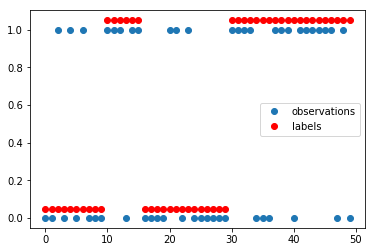

In [112]:
i = np.random.randint(1000)
plot(X_dataset[i], 'o')
plot(y_dataset[i] + 0.05, 'ro')
legend(['observations', 'labels'])

### Train CRF

In [113]:
def extract_features(x):
    features = [
        'x.current=' + str(x)
    ]
    return features

In [114]:
def extract_labels(y):
    return str(y)

#### Preprocess Dataset

In [115]:
X = []
y = []

for xseq, yseq in zip(X_dataset, y_dataset):
    X_features = [extract_features(x_i) for x_i in xseq]
    y_labels = [extract_labels(y_i) for y_i in yseq]
    
    X.append(X_features)
    y.append(y_labels)

#### Train-Test split 

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Train 

In [117]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [118]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0,
    c2=0,  # regulate this up to 1 if needed
    max_iterations=5000,
    all_possible_transitions=True,
    all_possible_states=True
)
crf.fit(X_train, y_train)

CPU times: user 192 ms, sys: 3.28 ms, total: 195 ms
Wall time: 195 ms


In [119]:
y_pred = crf.predict(X_test)

In [120]:
labels = list(crf.classes_)
labels

['1', '0']

In [121]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000      3775
           1      1.000     1.000     1.000      6225

   micro avg      1.000     1.000     1.000     10000
   macro avg      1.000     1.000     1.000     10000
weighted avg      1.000     1.000     1.000     10000



In [122]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

Transitions:
1      -> 1       359.975983
0      -> 0       315.672201
0      -> 1       -336.769906
1      -> 0       -338.878278


In [123]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("States:")
print_state_features(Counter(crf.state_features_).most_common(30))

States:
241.725664 1        x.current=1
234.406002 0        x.current=0
-234.406002 1        x.current=0
-241.725664 0        x.current=1


###  Training MPNN based model

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.2)

#### Define 

In [125]:
n_epochs = 50
batch_size = 64 # len(X_train) # 256

In [126]:
trainset = ChainDataset(X_train, y_train)
testset = ChainDataset(X_test, y_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=True, num_workers=2)

In [184]:
j = Variable(torch.tensor([20.]), requires_grad=True)
b = Variable(torch.tensor([-5., 10.]), requires_grad=True)

In [185]:
optimizer = optim.Adam([j, b], lr=0.1)

#### Train

In [186]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np


def belief_propagation_cross_entropy_loss(j, b, observations, labels, chain_len, train=True):
    batch_size = labels.size()[0]
    
    loss = 0
    
    labels_out = torch.Tensor()
    for b_idx in range(batch_size):

        values = torch.Tensor([0, 1]) - 0.5
        pairs = torch.mul(values.view(-1, 2).t(), values)
        unit_msg = torch.ones([2, 1]) / 2
        
        forward_messages = unit_msg
        msg_left = unit_msg # no information traveling left to x1
        
        # forward pass    
        for i in range(0, chain_len - 1):
            
            phi = torch.exp(torch.mul(b[int(observations[b_idx][i])], values))
            psi = torch.exp(torch.mul(j, pairs))
  
            step1 = torch.mul(phi, msg_left.t())
            step2 = torch.mul(step1, psi)
            step3, _ = torch.max(step2, dim=1)

            msg = step3.view(-1 ,1)
            norm_ = torch.norm(msg, p=1, dim=0)  # L1 norm
            msg = torch.div(msg, norm_)
            
            forward_messages = torch.cat((forward_messages, msg), dim=1)    
            msg_left = msg
        
        
        backward_messages = unit_msg
        msg_right = unit_msg # no information traveling right to x_n
        
        # backward pass    
        for i in range(chain_len - 1, 0, -1):

            phi = torch.exp(torch.mul(b[int(observations[b_idx][i])], values))
            psi = torch.exp(torch.mul(j, pairs))
            step1 = torch.mul(phi, msg_right.t())
            step2 = torch.mul(step1, psi)
            step3, _ = torch.max(step2, dim=1)

            msg = step3.view(-1 ,1)
            norm_ = torch.norm(msg, p=1, dim=0)  # L1 norm
            msg = torch.div(msg, norm_)
            
            backward_messages = torch.cat((msg, backward_messages), dim=1)    
            msg_right = msg

        # calculate message propagation
        messages = torch.mul(forward_messages, backward_messages)
        # add data term
        data_term = torch.Tensor()
        for i in range(0, chain_len):
            phi = torch.exp(torch.mul(b[int(observations[b_idx][i])], values))
            data_term = torch.cat((data_term, phi.view(-1, 1)), dim=1)
        
        # calculate beliefs
        beliefs = torch.mul(data_term, messages)
        norm_ = torch.norm(beliefs, p=1, dim=0)  # L1 norm
        beliefs_norm = torch.div(beliefs, norm_)
        
        beliefs_softmax = torch.softmax(beliefs_norm , dim=0)
        loss += F.binary_cross_entropy(beliefs_softmax[1, :].float(), labels[b_idx]) ###
        
        labels_out = torch.cat((labels_out, (beliefs_norm[1, :] > 0.5).float().view(1, -1)), dim=0)
        
    loss = torch.div(loss, batch_size)
    
    if train:
        return loss
    else:
        return labels_out

In [187]:
learning_curve = []

for epoch in range(1, n_epochs + 1):
    
    for batch in trainloader:
        X_batch, y_batch = Variable(batch['X'], requires_grad=False), Variable(batch['y'], requires_grad=False)
        
        print('J: {},  b0: {}, b1: {}'.format(j[0], b[0], b[1]))
        
        optimizer.zero_grad()
        loss = belief_propagation_cross_entropy_loss(j, b, X_batch, y_batch, chain_len=T)
        loss.backward()
        
        b.grad.data[1].fill_(0)  # take b[1] as constant
        print('JGrad: {},  bGrad: {}'.format(j.grad.data, b.grad.data))
    
        optimizer.step()
        
        
    if epoch % 1 == 0:
        valid = next(iter(validloader))
        X_valid, y_valid = Variable(valid['X']), Variable(valid['y']) 
        with torch.no_grad():
            loss_valid = belief_propagation_cross_entropy_loss(j, b, X_valid, y_valid, chain_len=T)

        print('>>>\t epoch {}:: loss = {}, validation loss = {}'. format(epoch, loss, loss_valid))
        learning_curve.append({
            'epoch': epoch + 1,
            'loss': loss,
            'loss_valid': loss_valid,
            'b': [b.data.clone()[0], b.data.clone()[1]],
            'j': j.data.clone()[0],
            'b_grad': [b.grad.data.clone()[0], b.grad.data.clone()[1]],
            'j_grad': j.grad.data.clone()[0]
        })

J: 20.0,  b0: -5.0, b1: 10.0
JGrad: tensor([0.0147]),  bGrad: tensor([0.1105, 0.0000])
J: 19.900001525878906,  b0: -5.099999904632568, b1: 10.0
JGrad: tensor([0.0120]),  bGrad: tensor([0.0965, 0.0000])
J: 19.801008224487305,  b0: -5.199422359466553, b1: 10.0
JGrad: tensor([0.0067]),  bGrad: tensor([0.0613, 0.0000])
J: 19.707578659057617,  b0: -5.294965744018555, b1: 10.0
JGrad: tensor([0.0095]),  bGrad: tensor([0.0901, 0.0000])
J: 19.613555908203125,  b0: -5.39171028137207, b1: 10.0
JGrad: tensor([0.0042]),  bGrad: tensor([0.0509, 0.0000])
J: 19.5252742767334,  b0: -5.485133171081543, b1: 10.0
JGrad: tensor([0.0058]),  bGrad: tensor([0.0487, 0.0000])
J: 19.43861198425293,  b0: -5.576122760772705, b1: 10.0
JGrad: tensor([0.0098]),  bGrad: tensor([0.0802, 0.0000])
J: 19.349197387695312,  b0: -5.668857574462891, b1: 10.0
JGrad: tensor([0.0074]),  bGrad: tensor([0.0648, 0.0000])
J: 19.259634017944336,  b0: -5.761552810668945, b1: 10.0
JGrad: tensor([0.0069]),  bGrad: tensor([0.0656, 0.0000

JGrad: tensor([-0.0074]),  bGrad: tensor([0.0131, 0.0000])
J: 23.01714324951172,  b0: -7.558677673339844, b1: 10.0
JGrad: tensor([-0.0069]),  bGrad: tensor([0.0255, 0.0000])
J: 23.125490188598633,  b0: -7.5749711990356445, b1: 10.0
JGrad: tensor([-0.0036]),  bGrad: tensor([0.0403, 0.0000])
J: 23.227745056152344,  b0: -7.601744651794434, b1: 10.0
JGrad: tensor([-0.0069]),  bGrad: tensor([0.0162, 0.0000])
J: 23.32806396484375,  b0: -7.630880832672119, b1: 10.0
JGrad: tensor([-0.0046]),  bGrad: tensor([0.0230, 0.0000])
J: 23.424123764038086,  b0: -7.6642045974731445, b1: 10.0
JGrad: tensor([-0.0097]),  bGrad: tensor([0.0082, 0.0000])
J: 23.521686553955078,  b0: -7.696921348571777, b1: 10.0
JGrad: tensor([-0.0063]),  bGrad: tensor([-0.0025,  0.0000])
J: 23.617155075073242,  b0: -7.725815296173096, b1: 10.0
JGrad: tensor([-0.0084]),  bGrad: tensor([0.0145, 0.0000])
J: 23.712919235229492,  b0: -7.7564697265625, b1: 10.0
JGrad: tensor([-0.0051]),  bGrad: tensor([0.0153, 0.0000])
J: 23.8054466

JGrad: tensor([0.0010]),  bGrad: tensor([0.0069, 0.0000])
J: 26.25017547607422,  b0: -8.06765365600586, b1: 10.0
JGrad: tensor([-0.0013]),  bGrad: tensor([0.0065, 0.0000])
J: 26.250396728515625,  b0: -8.073601722717285, b1: 10.0
JGrad: tensor([-0.0017]),  bGrad: tensor([-0.0175,  0.0000])
J: 26.253114700317383,  b0: -8.071806907653809, b1: 10.0
JGrad: tensor([0.0009]),  bGrad: tensor([0.0118, 0.0000])
J: 26.254182815551758,  b0: -8.075044631958008, b1: 10.0
JGrad: tensor([-0.0003]),  bGrad: tensor([0.0006, 0.0000])
J: 26.255542755126953,  b0: -8.078227996826172, b1: 10.0
JGrad: tensor([0.0002]),  bGrad: tensor([-0.0091,  0.0000])
J: 26.25649070739746,  b0: -8.077337265014648, b1: 10.0
JGrad: tensor([0.0009]),  bGrad: tensor([-0.0054,  0.0000])
J: 26.255910873413086,  b0: -8.074286460876465, b1: 10.0
JGrad: tensor([0.0010]),  bGrad: tensor([0.0085, 0.0000])
J: 26.2539119720459,  b0: -8.075063705444336, b1: 10.0
JGrad: tensor([0.0023]),  bGrad: tensor([0.0005, 0.0000])
>>>	 epoch 11:: lo

JGrad: tensor([-0.0005]),  bGrad: tensor([0.0226, 0.0000])
J: 26.16038703918457,  b0: -8.061405181884766, b1: 10.0
JGrad: tensor([0.0012]),  bGrad: tensor([0.0003, 0.0000])
J: 26.15731430053711,  b0: -8.081019401550293, b1: 10.0
JGrad: tensor([-6.9713e-05]),  bGrad: tensor([-0.0032,  0.0000])
J: 26.1546688079834,  b0: -8.097148895263672, b1: 10.0
JGrad: tensor([0.0006]),  bGrad: tensor([-0.0142,  0.0000])
J: 26.151264190673828,  b0: -8.10479736328125, b1: 10.0
JGrad: tensor([-0.0008]),  bGrad: tensor([-0.0145,  0.0000])
J: 26.149730682373047,  b0: -8.104620933532715, b1: 10.0
JGrad: tensor([-0.0030]),  bGrad: tensor([-0.0202,  0.0000])
>>>	 epoch 16:: loss = 0.32624804973602295, validation loss = 0.3289746940135956
J: 26.1539249420166,  b0: -8.094656944274902, b1: 10.0
JGrad: tensor([0.0006]),  bGrad: tensor([-0.0111,  0.0000])
J: 26.156679153442383,  b0: -8.080265045166016, b1: 10.0
JGrad: tensor([-0.0006]),  bGrad: tensor([0.0092, 0.0000])
J: 26.16031265258789,  b0: -8.07175731658935

JGrad: tensor([-0.0016]),  bGrad: tensor([-0.0084,  0.0000])
J: 26.15494728088379,  b0: -8.086299896240234, b1: 10.0
JGrad: tensor([-0.0019]),  bGrad: tensor([-0.0008,  0.0000])
J: 26.160146713256836,  b0: -8.094736099243164, b1: 10.0
JGrad: tensor([-2.5131e-05]),  bGrad: tensor([0.0028, 0.0000])
J: 26.164888381958008,  b0: -8.1038818359375, b1: 10.0
JGrad: tensor([0.0015]),  bGrad: tensor([-0.0296,  0.0000])
>>>	 epoch 21:: loss = 0.32833611965179443, validation loss = 0.3289923369884491
J: 26.16602325439453,  b0: -8.09598159790039, b1: 10.0
JGrad: tensor([0.0011]),  bGrad: tensor([-0.0073,  0.0000])
J: 26.164644241333008,  b0: -8.0848970413208, b1: 10.0
JGrad: tensor([-0.0001]),  bGrad: tensor([-0.0064,  0.0000])
J: 26.163652420043945,  b0: -8.071423530578613, b1: 10.0
JGrad: tensor([0.0004]),  bGrad: tensor([0.0047, 0.0000])
J: 26.16188621520996,  b0: -8.061841011047363, b1: 10.0
JGrad: tensor([-0.0016]),  bGrad: tensor([-0.0055,  0.0000])
J: 26.163681030273438,  b0: -8.050195693969

JGrad: tensor([-0.0004]),  bGrad: tensor([-0.0006,  0.0000])
>>>	 epoch 26:: loss = 0.327629417181015, validation loss = 0.32900142669677734
J: 26.172021865844727,  b0: -8.096942901611328, b1: 10.0
JGrad: tensor([0.0005]),  bGrad: tensor([0.0035, 0.0000])
J: 26.16998291015625,  b0: -8.104052543640137, b1: 10.0
JGrad: tensor([-0.0010]),  bGrad: tensor([-0.0103,  0.0000])
J: 26.17045783996582,  b0: -8.104350090026855, b1: 10.0
JGrad: tensor([0.0008]),  bGrad: tensor([-0.0176,  0.0000])
J: 26.16886329650879,  b0: -8.094159126281738, b1: 10.0
JGrad: tensor([-0.0013]),  bGrad: tensor([-0.0140,  0.0000])
J: 26.170547485351562,  b0: -8.076661109924316, b1: 10.0
JGrad: tensor([-0.0002]),  bGrad: tensor([-0.0023,  0.0000])
J: 26.172557830810547,  b0: -8.059503555297852, b1: 10.0
JGrad: tensor([-0.0007]),  bGrad: tensor([0.0040, 0.0000])
J: 26.17616081237793,  b0: -8.046435356140137, b1: 10.0
JGrad: tensor([-0.0010]),  bGrad: tensor([0.0052, 0.0000])
J: 26.181766510009766,  b0: -8.03775215148925

JGrad: tensor([-0.0004]),  bGrad: tensor([-0.0107,  0.0000])
J: 26.168842315673828,  b0: -8.09804916381836, b1: 10.0
JGrad: tensor([-0.0007]),  bGrad: tensor([0.0014, 0.0000])
J: 26.171079635620117,  b0: -8.092562675476074, b1: 10.0
JGrad: tensor([-0.0015]),  bGrad: tensor([-0.0047,  0.0000])
J: 26.177091598510742,  b0: -8.084665298461914, b1: 10.0
JGrad: tensor([-0.0010]),  bGrad: tensor([0.0011, 0.0000])
J: 26.185264587402344,  b0: -8.07826042175293, b1: 10.0
JGrad: tensor([-0.0011]),  bGrad: tensor([-0.0024,  0.0000])
J: 26.195526123046875,  b0: -8.070964813232422, b1: 10.0
JGrad: tensor([0.0008]),  bGrad: tensor([0.0067, 0.0000])
J: 26.20258331298828,  b0: -8.068625450134277, b1: 10.0
JGrad: tensor([0.0004]),  bGrad: tensor([-0.0095,  0.0000])
J: 26.207969665527344,  b0: -8.06043815612793, b1: 10.0
JGrad: tensor([0.0012]),  bGrad: tensor([-0.0029,  0.0000])
J: 26.2095947265625,  b0: -8.051225662231445, b1: 10.0
JGrad: tensor([0.0005]),  bGrad: tensor([0.0047, 0.0000])
J: 26.2097873

JGrad: tensor([0.0020]),  bGrad: tensor([0.0203, 0.0000])
J: 26.177980422973633,  b0: -7.962503910064697, b1: 10.0
JGrad: tensor([0.0026]),  bGrad: tensor([0.0218, 0.0000])
J: 26.176939010620117,  b0: -7.969887733459473, b1: 10.0
JGrad: tensor([0.0027]),  bGrad: tensor([0.0323, 0.0000])
J: 26.168258666992188,  b0: -7.997818470001221, b1: 10.0
JGrad: tensor([0.0006]),  bGrad: tensor([0.0143, 0.0000])
J: 26.158832550048828,  b0: -8.0324068069458, b1: 10.0
JGrad: tensor([4.5139e-09]),  bGrad: tensor([0.0077, 0.0000])
J: 26.150339126586914,  b0: -8.068648338317871, b1: 10.0
JGrad: tensor([0.0014]),  bGrad: tensor([-0.0023,  0.0000])
J: 26.13873291015625,  b0: -8.099778175354004, b1: 10.0
JGrad: tensor([-0.0024]),  bGrad: tensor([-0.0010,  0.0000])
J: 26.135168075561523,  b0: -8.127144813537598, b1: 10.0
JGrad: tensor([0.0009]),  bGrad: tensor([-0.0062,  0.0000])
J: 26.129474639892578,  b0: -8.14765739440918, b1: 10.0
JGrad: tensor([-0.0010]),  bGrad: tensor([-0.0075,  0.0000])
>>>	 epoch 3

JGrad: tensor([0.0004]),  bGrad: tensor([0.0150, 0.0000])
J: 26.209375381469727,  b0: -8.066534996032715, b1: 10.0
JGrad: tensor([0.0003]),  bGrad: tensor([-0.0140,  0.0000])
J: 26.210094451904297,  b0: -8.066177368164062, b1: 10.0
JGrad: tensor([-0.0005]),  bGrad: tensor([-0.0033,  0.0000])
J: 26.212142944335938,  b0: -8.063594818115234, b1: 10.0
JGrad: tensor([0.0040]),  bGrad: tensor([0.0181, 0.0000])
J: 26.201921463012695,  b0: -8.073652267456055, b1: 10.0
JGrad: tensor([-0.0010]),  bGrad: tensor([0.0023, 0.0000])
J: 26.195789337158203,  b0: -8.08428955078125, b1: 10.0
JGrad: tensor([0.0002]),  bGrad: tensor([-0.0135,  0.0000])
>>>	 epoch 42:: loss = 0.32902032136917114, validation loss = 0.3290405571460724
J: 26.189794540405273,  b0: -8.084630012512207, b1: 10.0
JGrad: tensor([-0.0019]),  bGrad: tensor([-0.0010,  0.0000])
J: 26.190149307250977,  b0: -8.084218978881836, b1: 10.0
JGrad: tensor([-0.0007]),  bGrad: tensor([-0.0023,  0.0000])
J: 26.192462921142578,  b0: -8.082276344299

JGrad: tensor([0.0004]),  bGrad: tensor([0.0265, 0.0000])
J: 26.225587844848633,  b0: -8.028494834899902, b1: 10.0
JGrad: tensor([-3.1781e-05]),  bGrad: tensor([-0.0040,  0.0000])
J: 26.234521865844727,  b0: -8.001652717590332, b1: 10.0
JGrad: tensor([-0.0002]),  bGrad: tensor([0.0067, 0.0000])
>>>	 epoch 47:: loss = 0.3249165713787079, validation loss = 0.33011651039123535
J: 26.243144989013672,  b0: -7.9821271896362305, b1: 10.0
JGrad: tensor([0.0009]),  bGrad: tensor([0.0183, 0.0000])
J: 26.24803924560547,  b0: -7.97737455368042, b1: 10.0
JGrad: tensor([0.0011]),  bGrad: tensor([0.0216, 0.0000])
J: 26.24873161315918,  b0: -7.988150596618652, b1: 10.0
JGrad: tensor([0.0016]),  bGrad: tensor([0.0071, 0.0000])
J: 26.244260787963867,  b0: -8.002779960632324, b1: 10.0
JGrad: tensor([-0.0009]),  bGrad: tensor([0.0019, 0.0000])
J: 26.24327278137207,  b0: -8.01728343963623, b1: 10.0
JGrad: tensor([-0.0003]),  bGrad: tensor([0.0034, 0.0000])
J: 26.243379592895508,  b0: -8.032743453979492, b1

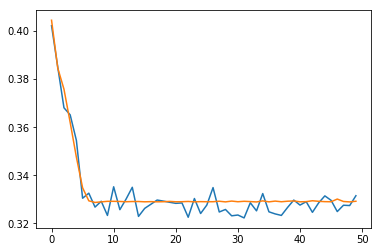

In [188]:
plot([(v['loss'], v['loss_valid']) for v in learning_curve]);

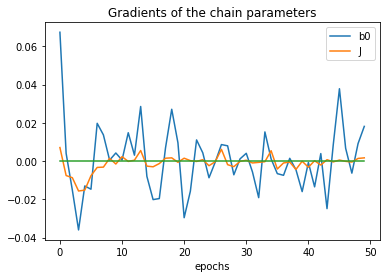

In [199]:
plot([(v['b_grad'][0], v['j_grad'],  v['b_grad'][1]) for v in learning_curve]);
title('Gradients of the chain parameters')
xlabel('epochs')
legend(['b0', 'J'])

Text(0.5, 0, 'epochs')

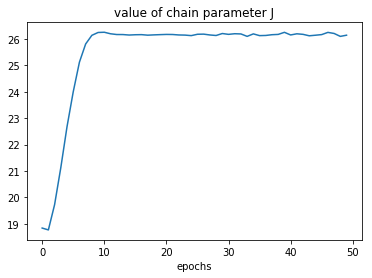

In [196]:
plot([v['j'] for v in learning_curve]);
title('value of chain parameter J')
xlabel('epochs')

Text(0.5, 0, 'epochs')

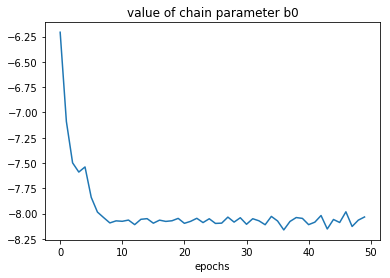

In [197]:
plot([v['b'][0] for v in learning_curve]);
title('value of chain parameter b0')
xlabel('epochs')

### Evaluate 

In [63]:
y_pred = belief_propagation_cross_entropy_loss(j, b, X_test, torch.Tensor(y_test), chain_len=T, train=False)\
    .detach()\
    .numpy()

In [64]:
labels = {0 : 0, 1: 1}

predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in y_test for tag in row])

print(classification_report(
    truths, predictions,
    target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.61      0.93      0.74      3661
           1       0.94      0.66      0.78      6339

   micro avg       0.76      0.76      0.76     10000
   macro avg       0.78      0.80      0.76     10000
weighted avg       0.82      0.76      0.76     10000



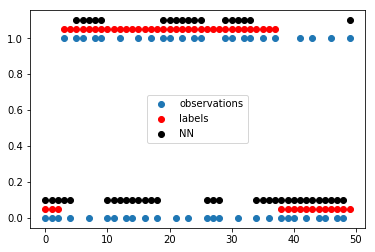

In [65]:
i = np.random.randint(200)
plot(X_test[i], 'o')
plot(y_test[i] + 0.05, 'ro')
plot(y_pred[i] + 0.1, 'ko')
legend(['observations', 'labels', 'NN'])

### Sanity - check that we can reach loss zero

In [141]:
ind = np.random.randint(1000)
j = [2.5] #[1]
b = [-0.8, 1.]
labels = y_dataset[ind]
observations = X_dataset[ind]

In [142]:
labels.shape, observations.shape

((50,), (50,))

In [143]:
# add batch dimension

In [144]:
labels = np.expand_dims(labels, axis=0)
observations = np.expand_dims(observations, axis=0)

In [145]:
# move to tensors

In [146]:
import torch

In [147]:
j = torch.Tensor(j)
b = torch.Tensor(b)
labels = torch.Tensor(labels)
observations = torch.Tensor(observations)

In [148]:
%%time
loss = belief_propagation_cross_entropy_loss(j, b, observations, labels, chain_len=T)
beliefs = belief_propagation_cross_entropy_loss(j, b, observations, labels, chain_len=T, train=False)[-1]

CPU times: user 15 ms, sys: 1.31 ms, total: 16.3 ms
Wall time: 15.2 ms


In [149]:
loss, torch.eq(labels, beliefs.float()), torch.all(torch.eq(labels, beliefs.float()))

(tensor(0.4884),
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1]], dtype=torch.uint8),
 tensor(1, dtype=torch.uint8))

In [150]:
labels

tensor([[1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [140]:
beliefs

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.])

###  Plot the loss function

####  target loss

In [177]:
j = [2.5]
b = [-0.8, 1.]

len_ = len(X_train[:10])

j = torch.Tensor(j)
b = torch.Tensor(b)

observations = torch.Tensor(X_train[:10])
labels = torch.Tensor(y_train[:10])

target_loss = belief_propagation_cross_entropy_loss(j, b, observations, labels, chain_len=T)
beliefs = belief_propagation_cross_entropy_loss(j, b, observations, labels, chain_len=T, train=False)

target_loss, int(torch.all(torch.eq(labels, beliefs.float())))

(tensor(0.4877), 1)

#### Plot loss surface

In [178]:
bar = progressbar.ProgressBar(maxval=3000, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

In [179]:
res = {'b0': [], 'b1': [], 'j': [], 'loss': [], 'zero_one_loss': []}

bar.start()
for i_sample in range(3000):
    bar.update(i_sample + 1)
    j_val = 2.5 + 5 * (np.random.rand() - 0.5)
    b_base = [2 * (np.random.rand() - 0.5) , 1]
  
    j = torch.Tensor([j_val])
    b = torch.Tensor(b_base)
    
    labels = torch.Tensor(y_train[:10])
    observations = torch.Tensor(X_train[:10])
    
    res['b0'].append(b_base[0])
    res['b1'].append(b_base[1])
    res['j'].append(j_val)
    res['loss'].append(float(belief_propagation_cross_entropy_loss(j, b, observations, labels, chain_len=T)))
    
    beliefs = belief_propagation_cross_entropy_loss(j, b, observations, labels, chain_len=T, train=False)
    res['zero_one_loss'].append(int(torch.all(torch.eq(labels, beliefs.float()))))
    
bar.finish()

[========================================================================] 100%


In [180]:
df = pd.DataFrame(res)

In [181]:
df.zero_one_loss.value_counts()

0    2995
1       5
Name: zero_one_loss, dtype: int64

In [183]:
import plotly.graph_objects as go

trace = go.Scatter3d(
        x=df['b0'],
        y=df['j'], 
        z=df['loss'], 
        mode='markers',
        marker=dict(
            size=10,
            color=df['zero_one_loss'],                # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=0.8
        ),
)

data = [trace]

scene = go.layout.Scene(
        annotations=[
            dict(
                x=-.8,
                y=2.5,
                z=target_loss,
                text="target",
                textangle=0,
                ax=0,
                ay=-75,
                font=dict(
                    color="red",
                    size=18
                ),
                arrowcolor="red",
                arrowsize=3,
                arrowwidth=1,
                arrowhead=1
        )],
)

fig = go.Figure()
fig.add_trace(trace)
fig.update_layout(scene=scene)
fig.write_html('loss_vs_data_term.html', auto_open=True)